---

<div align=center>
<a href='https://mp.weixin.qq.com/mp/appmsgalbum?__biz=Mzg2OTU4NzI3NQ==&action=getalbum&album_id=1764511202329624577&scene=126#wechat_redirect'> 
<img src=https://github.com/datoujinggzj/WhaleDataAnalysisProject/blob/master/pic/shanghai.png?raw=true width='400' />
</div>

👇👇👇点击可跳转！

[第二阶段：数据处理&数据分析](#第二阶段：数据处理&数据分析)

- [数据处理](#数据处理)
   - [中国时序数据处理](#中国时序数据处理)
   - [美国时序数据处理](#美国时序数据处理)
   - [中美横截面数据处理](#中美横截面数据处理)


<div class="alert alert-block alert-danger">
<b>注意：</b>

- 需要翻墙才可下载数据和观看油管视频哦！
- 在线看HTML显示不全，请下载到本地操作哦！
- 记得解锁代码再去run哦！
    
</div>

<div class="alert alert-block alert-warning">
<b>【上海新冠疫情数据分析】项目日志</b>

第二阶段：【数据预处理】
    
第二节阶段核心目的：数据清洗、处理以及转化
    
难度（最高5星）：⭐⭐⭐

Good Luck!
</div>


# 第二阶段：数据预处理

In [1]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
from tabulate import tabulate
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

## 数据处理

首先，我们要处理上一阶段得到的时间序列、横截面数据。

时间序列数据：

- time_series_covid19_confirmed_US.csv
- time_series_covid19_confirmed_global.csv
- time_series_covid19_deaths_US.csv
- time_series_covid19_deaths_global.csv
- time_series_covid19_recovered_global.csv

横截面数据：

- csse_covid_19_daily_reports
- csse_covid_19_daily_reports_us

正在读取【横截面】数据......
读取完毕
正在读取【时间序列】数据......
读取完毕
正在获取并处理【上海】数据（数据来自上海卫健委）......
读取完毕


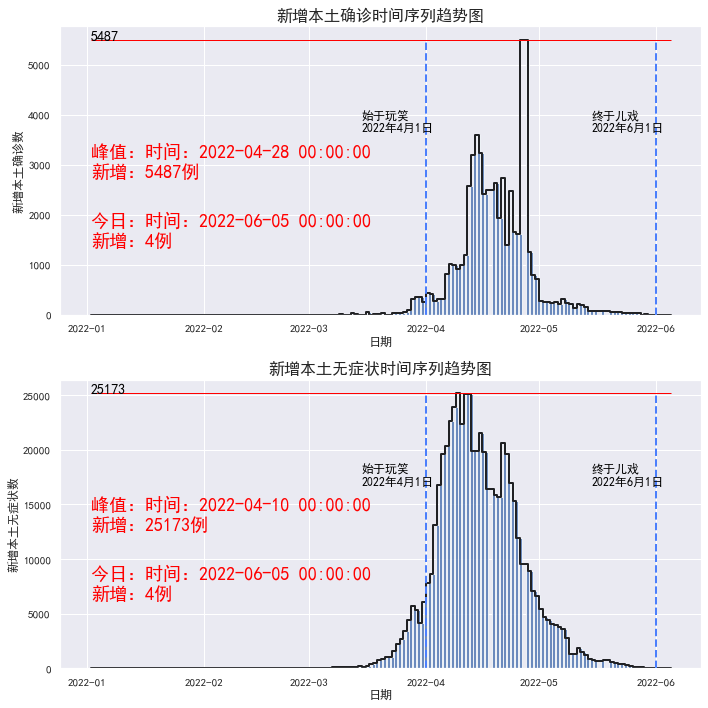

In [5]:
from getdata import GET_csse_covid_19_daily_reports,GET_csse_covid_19_time_series,GET_shanghai_data

# get data
latest_data_global,prev_data_global,latest_data_us,prev_data_us = GET_csse_covid_19_daily_reports()
ts_confirmed_us,ts_confirmed_global,ts_deaths_us,ts_deaths_global,ts_recovered_global = GET_csse_covid_19_time_series()
ts_shanghai_covid = GET_shanghai_data(plot=True)  # 这里包含近10天的上海无症状新增趋势！

### 中国时序数据处理

我们先来看看爬取的数据是什么样子的！先看国际的时间序列数据：ts_confirmed_global。

<div class="alert alert-block alert-success"><b>Step 1 Check the Data</b>

检查前五行数据并说明各个字段的含义，关于如何转化以时间为索引的数据框，你有什么想法？

</div>

In [6]:
ts_confirmed_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/29/22,5/30/22,5/31/22,6/1/22,6/2/22,6/3/22,6/4/22,6/5/22,6/6/22,6/7/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,180174,180259,180347,180419,180520,180584,180615,180615,180688,180741
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,276101,276101,276101,276221,276221,276310,276342,276401,276415,276468
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,265873,265877,265884,265887,265889,265889,265889,265897,265900,265904
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,42894,42894,42894,42894,42894,43067,43067,43067,43067,43067
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,99527,99761,99761,99761,99761,99761,99761,99761,99761,99761


可以看出，我们可以根据Country/Region筛选出China的所有数据，并且我们需要把横着的日期，转换成竖着的，是不是可以试试【转置】呢？

In [7]:
data1 = ts_confirmed_global.copy() # 不要原地操作，记得copy
# （1）Country/Region筛选出China的所有数据
data1 = data1[data1['Country/Region'] == 'China']
# （2）把Province/State设置成index
data1 = data1.set_index('Province/State')
# （3）'Country/Region','Lat','Long' 去除这三列，我们暂时不要。
data1 = data1.drop(['Country/Region','Lat','Long'],axis=1)
# （4）通过累计数计算新增数，也就是横着看，后一天的减去前一天的

### 1. axis=1 表示横着减
### 2. fillna 是因为后面的减去前一个，那么第一个值就会变成NaN，所以需要填充，我们填充为第一列本来的值即可
### 3. 在填充之后，为了保留原始数据类型，省着你用.astype再去转换，这里用downcast = 'infer'，具体见下方视频！

######## 重要！########
# .clip(lower=0) 是否加在最后面，取决于我们是否负略负增长，就是会存在你算出的difference是负值，这一句代码就会把所有负值换成0。
data1 = data1.diff(axis=1).fillna({data1.columns[0]:data1[data1.columns[0]]},downcast = 'infer') # .clip(lower=0)


# （5）我们按照最后一天(也就是最新一天)的新增从小到大排列，使用sort_values，根据data的最后一列的值，倒序排列即可。
data1 = data1.sort_values(by = data1.columns[-1],ascending=False)
# （6）转置（相当于90度大翻转）
data1 = data1.T
# （7）去除 Unknown 这一列，因为这时候index和column互换了，原先的index是Province/State，这里存在缺失值（估计是台湾？）叫做Unknown，去掉它。
data1 = data1.dropna().drop('Unknown',axis=1)
# （8）时间转换，此时，我们需要把时间用 pd.to_datetime 进行转换！You are almost there! 加油！
data1.index = pd.to_datetime(data1.index)
# （9）去除columns name

data1.columns.name = ''

ts_data_processed = data1
# 现在我们来看看处理好的数据！

# ts_data_processed 
# 解锁！

<div class="alert alert-block alert-danger">
<b>注意：</b>

不了解fillna的话可以看一下我的小红书视频哦（下方），第9分钟讲解了参数 `downcast`。
    
</div>

In [9]:
IFrame(width="853",height="480",src = "http://v.xiaohongshu.com/01e24207c120206a018370037fd1f059f3_259.mp4?sign=e28ad69986fb798216627daeda15a43d&t=62a36a80")

In [10]:
def ts_process_CHINA(ts_data,clip = False):
    ts_data = ts_data[ts_data['Country/Region'] == 'China']
    # get loc
    loc_data = ts_data[['Province/State','Lat','Long']]
    loc_data = loc_data[loc_data['Province/State'] != 'Unknown']

    ts_data = ts_data.set_index('Province/State').drop(['Country/Region','Lat','Long'],axis=1)
    if clip:
        ts_data = ts_data.diff(axis=1).fillna({ts_data.columns[0]:ts_data[ts_data.columns[0]]},downcast = 'infer').clip(lower=0)
    else:
        ts_data = ts_data.diff(axis=1).fillna({ts_data.columns[0]:ts_data[ts_data.columns[0]]},downcast = 'infer')
    ts_data = ts_data.sort_values(by = ts_data.columns[-1],ascending=False)
    ts_data = ts_data.T.dropna().drop('Unknown',axis=1)
    ts_data.index = pd.to_datetime(ts_data.index)
    ts_data.columns.name = ''
    sorted_provinces = ts_data.columns
    return ts_data,loc_data,sorted_provinces #### loc_data,sorted_provinces 这两个输出先忽略

同理我们是不是可以再去对美国的数据也进行这样的处理呢？交给你吧！

### 美国时序数据处理

In [11]:
ts_confirmed_us.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/29/22,5/30/22,5/31/22,6/1/22,6/2/22,6/3/22,6/4/22,6/5/22,6/6/22,6/7/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15939,15939,15963,15969,15978,15978,15978,15978,16032,16052
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,56329,56329,56512,56580,56648,56648,56648,56648,56895,56955
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,5695,5695,5707,5710,5714,5714,5714,5714,5719,5733
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,6491,6491,6500,6508,6512,6512,6512,6512,6534,6535
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,15061,15061,15073,15077,15084,15084,15084,15084,15096,15112


可以看到，美国的数据比国际的数据要复杂不少，多了一些维度！

<div class="alert alert-block alert-success"><b>Step 2 Process the US ts Data</b>

处理美国的时间序列数据，参考上方教程！
    
注意：美国的数据计算到了county层面，我们不需要这么详细，我们统计到state即可，就是group by state并且sum所有的case即可。
    
【Question】写一个函数，输入为ts_data，当death是True时，我们处理的为ts_deaths_us（结构和ts_confirmed_us有区别！），clip默认为False，因为我们允许负增长的出现！

你的函数应该使用于以下数据：
    
- ts_confirmed_us
- ts_deaths_us

</div>

供参考👇👇👇

In [12]:
def ts_process_US(ts_data, death = False, clip = False):
    "你的答案写在这！"

下面，我们再继续处理横截面数据！

### 中美横截面数据处理

我们以最新的全球横截面数据做例子 latest_data_global

In [13]:
latest_data_global.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2022-06-08 04:20:55,33.93911,67.709953,180741,7709,NaN,NaN,Afghanistan,464.291556,4.265219
1,NaN,NaN,NaN,Albania,2022-06-08 04:20:55,41.15330,20.168300,276468,3497,NaN,NaN,Albania,9606.921954,1.264884
2,NaN,NaN,NaN,Algeria,2022-06-08 04:20:55,28.03390,1.659600,265904,6875,NaN,NaN,Algeria,606.380104,2.585520
3,NaN,NaN,NaN,Andorra,2022-06-08 04:20:55,42.50630,1.521800,43067,153,NaN,NaN,Andorra,55739.338640,0.355260
4,NaN,NaN,NaN,Angola,2022-06-08 04:20:55,-11.20270,17.873900,99761,1900,NaN,NaN,Angola,303.536136,1.904552


这里，我们需要提取中国和美国的横截面数据，需要的字段是：

'Province_State',
'Last_Update',
'Confirmed',
'Deaths',
'Incident_Rate',
'Case_Fatality_Ratio'

index是各省或各州

大家可以尝试一下！

<div class="alert alert-block alert-success"><b>Step 3 Process the Cross Sectional Data</b>

处理中美的横截面数据，参考上方说明！
    
country 为 'China'，要先在全球数据中摘取中国数据，并去除Unknown！

</div>

In [14]:
def daily_process(daily_data, country = 'China'):
    "你的答案！"

In [15]:
daily_process(latest_data_global, country = 'China')

,Province_State,Last_Update,Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio
,,,,,,
Anhui,Anhui,2022-06-08 04:20:55,1065,6,1.684061,0.563380
Beijing,Beijing,2022-06-08 04:20:55,3436,9,15.951718,0.261932
Chongqing,Chongqing,2022-06-08 04:20:55,714,6,2.301741,0.840336
Fujian,Fujian,2022-06-08 04:20:55,3311,1,8.401421,0.030202
Gansu,Gansu,2022-06-08 04:20:55,681,2,2.582480,0.293686
Guangdong,Guangdong,2022-06-08 04:20:55,7320,8,6.451613,0.109290
Guangxi,Guangxi,2022-06-08 04:20:55,1644,2,3.337393,0.121655
Guizhou,Guizhou,2022-06-08 04:20:55,185,2,0.513889,1.081081
Hainan,Hainan,2022-06-08 04:20:55,288,6,3.083512,2.083333


现在，我们再把所有的函数写入一个模块，叫做：data_processing。

In [17]:
from data_processing import ts_process_CHINA,ts_process_US,daily_process

In [18]:
ts_confirmed_CHINA_incre, loc_data_CHINA, sorted_provinces = ts_process_CHINA(ts_confirmed_global,clip=False)
ts_deaths_CHINA_incre, _, _ = ts_process_CHINA(ts_deaths_global,clip=False)
ts_recovered_CHINA_incre, _, _ = ts_process_CHINA(ts_recovered_global,clip=False)

In [19]:
ts_confirmed_US_incre,loc_data_us,sorted_state = ts_process_US(ts_confirmed_us,clip=False)
ts_deaths_US_incre,_,_,population = ts_process_US(ts_deaths_us,death = True,clip=False)

In [20]:
latest_data_CHINA = daily_process(latest_data_global, country = 'China')
prev_data_CHINA = daily_process(prev_data_global, country = 'China')
latest_data_US = daily_process(latest_data_us, country = 'US')
prev_data_US = daily_process(prev_data_us, country = 'US')